# Importing libraries and loading data

In [1]:
import tensorflow as tf
import xgboost as xgb
import xgboost
import tensorflow
import numpy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras import regularizers
from sklearn.svm import SVR
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import LSTM
from tensorflow.python.keras import initializers
from datetime import datetime as dt
from utils import *
from sklearn.ensemble import RandomForestRegressor
from features_engineering import TIME_SERIES_FEATURES_ENGINEERING
import sklearn
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA    
import numpy as np
import math
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
start=dt.now()

Using TensorFlow backend.


# Process weathertypes, remove empty windspeed and store (ignore if it's already done)

In [2]:
#If you want to generate the one_hot file uncomment the last line of this cell
def update_one_hot_data(combined_path,weather_combined_path):
    if not check_if_the_tsv_hot_file_already_has_processed_columns(weather_combined_path):        
        
        df = pd.read_csv(combined_path,
                         sep='\t',
                         header=0) 
        weather_unique_combinations = df.weather_condition.unique()

        #Get list of all unique weather types
        types = []
        for el in weather_unique_combinations:
            for wc in el.split('.'):
                if(wc != ''):            
                    types.append(wc.strip())
        true_unique =  set(types)

        #Add columns with default value 0 for all unique weather types
        for unique_weather_type in true_unique:
            df[unique_weather_type]=0

        #Loop over all records and set value to 1 for their corresponding weather_types
        for index, row in df.iterrows():
            row_types = []
            for wc in row["weather_condition"].split('.'):
                if(wc != ''):            
                    row_types.append(wc.strip())
            for t in row_types:
                df.at[index,t]=1


        #remove empty windspeeds
        df = df[df.wind_speed.apply(lambda x: str(x).isnumeric())]

        #remove original weather_condition column and store, to avoid rerun
        df =  df.drop(columns="weather_condition")
        df.to_csv(weather_combined_path,
                  sep='\t',
                  index=False,
                  header=True) 
        TIME_SERIES_FEATURES_ENGINEERING(weather_combined_path)
    else:
        print("File already processed.")
        
combined_path = ".././data/combined_data.tsv"
weather_combined_path=".././data/combined_one_hot_data.tsv"
#update_one_hot_data(combined_path,weather_combined_path)

# Loadin data with one_hot weather types

In [3]:
def select_data_from_lat_csv(data,latitude):

    return data[data['latitude']==latitude]
def obtain_latitudes_list(latitude_data):
    return latitude_data.unique()
weather_combined_path=".././data/combined_one_hot_data.tsv"
df = pd.read_csv(weather_combined_path,
                 sep='\t',
                 header=0)
print(df.shape)
lat_list=obtain_latitudes_list(df.latitude)
pole=5
df=select_data_from_lat_csv(df,lat_list[pole])
print("Selecting data for bikes station on latitude "+str(lat_list[pole]))
#print(lat_list)
print(df.shape)

#choose one station to test on
#df=df[df['device_name']=='CB1143']
#print(df)

(101461, 48)
Selecting data for bikes station on latitude 50.85363
(15277, 48)


# Remove outliers (bike_count)

In [4]:
def remove_outlier(df_in, col_name):
    """Removes all outliers on a specific column from a given dataframe.

    Args:
        df_in (pandas.DataFrame): Iput pandas dataframe containing outliers
        col_name (str): Column name on which to search outliers

    Returns:
        pandas.DataFrame: DataFrame without outliers
    """         
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1  # Interquartile range
    fence_low = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    return df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)] 
start_size=df.shape[0]
df = remove_outlier(df, "bike_count")
print(df.shape)
print("We have removed "+str(start_size-df.shape[0])+" outliers tuples (which is "+str((start_size-df.shape[0])/start_size*100)+" % of total).")

(14422, 48)
We have removed 855 outliers tuples (which is 5.596648556653793 % of total).


# Feature selection

In [5]:
def remove_features(df):
    return df.drop(columns=[        
    'device_name',
    'timestamp_until',
    'bike_avg_speed',
    'weather_timestamp',
    'wind_direction',
    'wind_speed',
    'barometer',
    'visibility',
    'Ice fog',
    'Thundershowers',
    'Sprinkles',
    'Broken clouds',
    'Rain showers',
    'Snow flurries',
    'Light fog',
    'Sleet',
    'Cloudy',
    'Quite cool'    
])
def remove__weather_features(df):
    return df.drop(columns=[        
    'temperature',
    'humidity',
    'Scattered showers',
    'Low clouds',
    'Snow',
    'Snow showers',
    'Thunderstorms',
    'Partly sunny',
    'Light freezing rain',
    'Sunny',
    'Light rain',
    'Freezing rain',
    'Light snow',
    'Passing clouds',
    'Fog',
    'Cool',
    'Partly cloudy',
    'Haze',
    'Hail',
    'Scattered clouds',
    'Drizzle',
    'Clear',
    'Rain',
    'Chilly'    
        
])
def remove__all_features_for_ARIMA_Model(df):
    return df.drop(columns=[        
    'temperature',
    'latitude',
    'longitude',
    'time_window',
    'time_day_of_week_window',
    'humidity',
    'Scattered showers',
    'Low clouds',
    'Snow',
    'Snow showers',
    'Thunderstorms',
    'Partly sunny',
    'Light freezing rain',
    'Sunny',
    'Light rain',
    'Freezing rain',
    'Light snow',
    'Passing clouds',
    'Fog',
    'Cool',
    'Partly cloudy',
    'Haze',
    'Hail',
    'Scattered clouds',
    'Drizzle',
    'Clear',
    'Rain',
    'Chilly' 
        
])

df=remove_features(df)
df=remove__all_features_for_ARIMA_Model(df)
#df=remove__weather_features(df)
print(df.head())
print(df.columns)
print(df.shape)

       timestamp_from  bike_count
62516      1544095800           3
62517      1544096700          23
62518      1544097600          23
62519      1544098500          12
62520      1544099400          13
Index(['timestamp_from', 'bike_count'], dtype='object')
(14422, 2)


# Creating ARIMA model

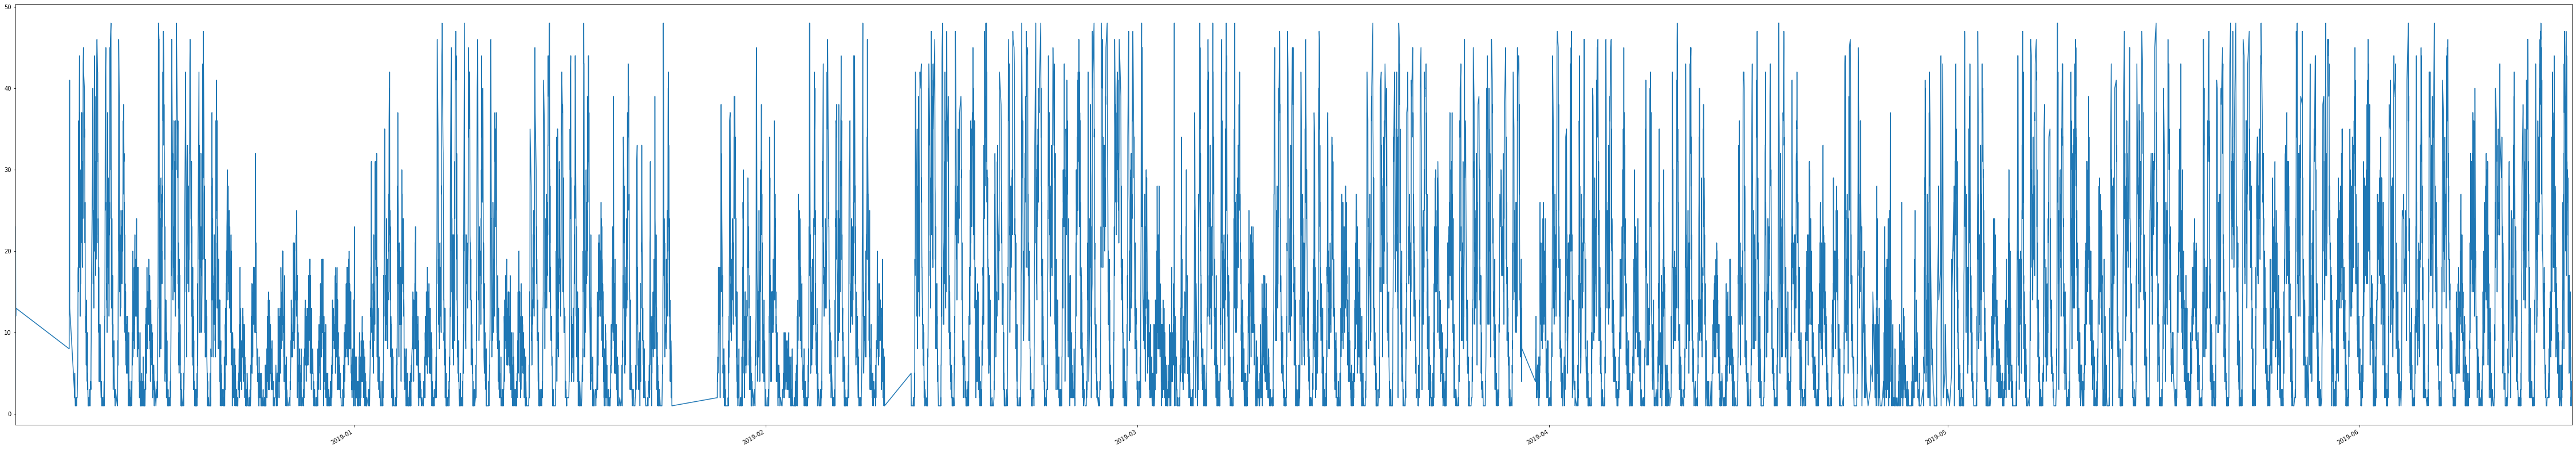

Calculating ARIMA scores...
Test RMSE:  6.1717077535819245
Test MAE :  4.461046299993246
Test MSE : 38.090


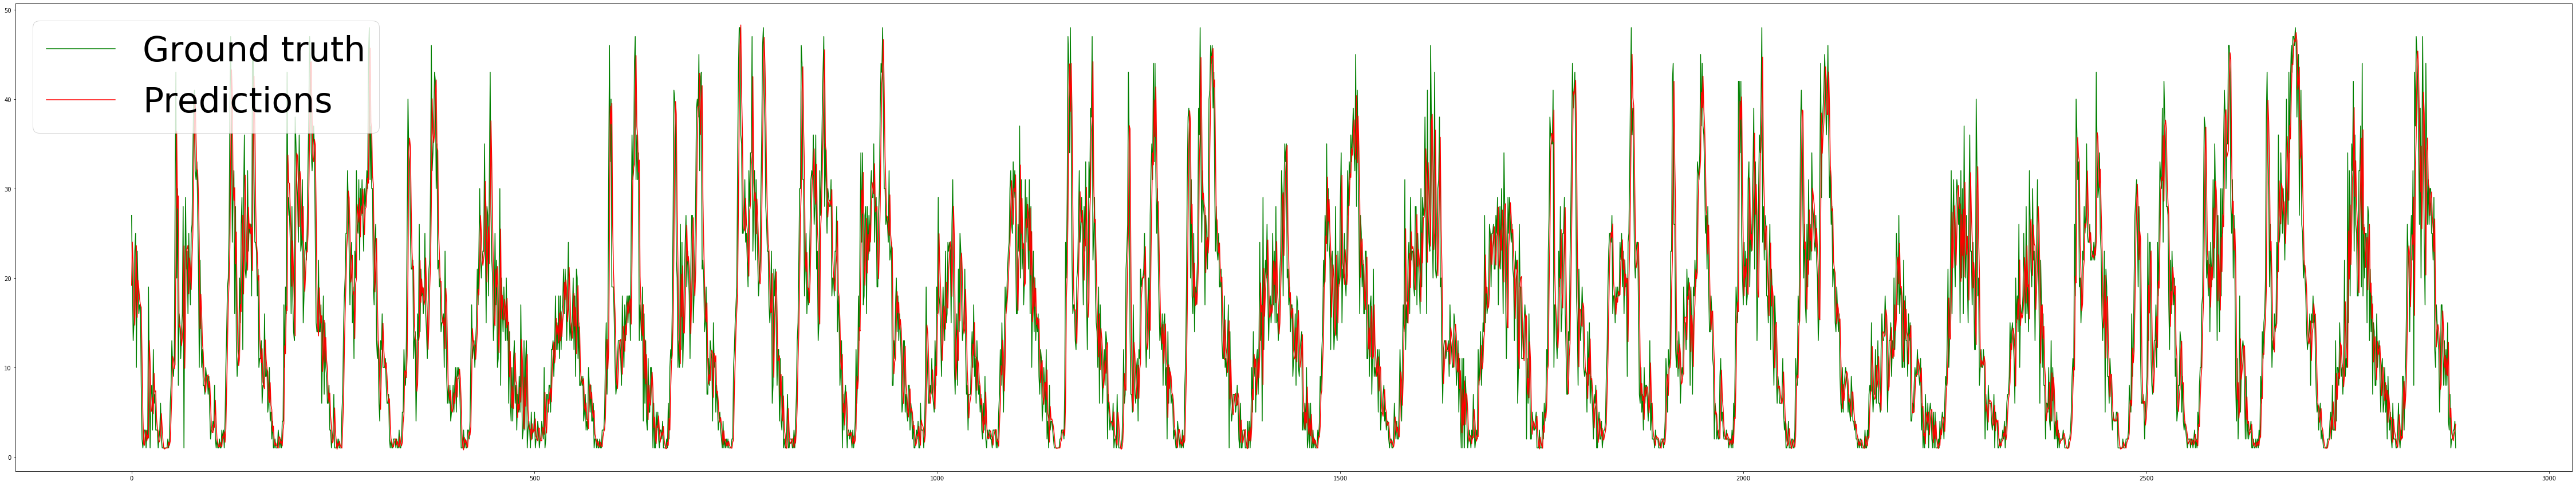

In [6]:
def plot_data_series(data_series):
    if isinstance(data_series,pd.core.series.Series):        
        data_series.plot(figsize=(80,15))
        pyplot.show()
    else:        
        timestamp_list=[]
        for i in df.timestamp_from.values:     
            timestamp_list.append(datetime.fromtimestamp(int(i)))               
        data=pd.Series(df.bike_count.values,index=timestamp_list)        
        data.plot(figsize=(80,15))
        pyplot.show()     
def plot_prediction_results(pred, df, size):
    timestamp_list=[]
    new_pred=[]
    for i in pred:
        new_pred.append(float(i))
    print(new_pred)
    input()
    for i in df.timestamp_from.values[size:]:     
        timestamp_list.append(datetime.fromtimestamp(int(i)))
    data=pd.Series(new_pred,df.bike_count.values[size:],index=timestamp_list)
    print(data)
    print(type(pred[0]))
    data.plot(figsize=(80,15))
    pyplot.show() 
def ARIMA_grid_search(df):
    p_grid_search_values_list=[5,8,10]
    grid_search_values_list=[0,1,2,3,4]  
    best=1000
    string_best=""
    for p in p_grid_search_values_list:
        for q in grid_search_values_list:
            for d in grid_search_values_list:                       
                print("Calculating grid search scores...")
                print('p',p)
                print('q',q)
                print('d',d)
                X = df.bike_count.values         
                size = int(len(X) * 0.999)
                train, test = X[0:size], X[size:len(X)]
                history = [x for x in train]
                predictions = list()
                for t in range(len(test)):                    
                    model = ARIMA(history, order=(p,q,d))
                    model_fit = model.fit(disp=0)
                    output = model_fit.forecast()
                    yhat = output[0]
                    predictions.append(yhat)
                    obs = test[t]
                    history.append(obs)          
                error = mean_squared_error(test, predictions)
                mae=mean_absolute_error(test,predictions)
                if math.sqrt(error)<best:
                    print("New best",math.sqrt(error))
                    best=math.sqrt(error)
                    string_best="p: "+str(p)+" q: "+str(q)+"d: "+str(d)
                print("Test RMSE:  "+str(math.sqrt(error)))
                print('Test MAE :  ' + str(mae))
                print('Test MSE : %.3f' % error)              
                pyplot.rcParams['figure.figsize'] = [80, 15]       
                pyplot.plot(test,color='green')
                pyplot.plot(predictions, color='red')
                pyplot.legend(['Ground truth','Predictions'],prop={'size': 60})
                pyplot.show()
                print("XXXXXXXXXXXXXXXXX**********XXXXXXXXXXXXXXXX")
    print("best is ",best)
    print(string_best)    
def ARIMA_bikes(): 
    def parser(x):        
        return datetime.fromtimestamp(int(x))
#     series = read_csv('point_50.82448.tsv',sep='\t', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)    
    count=0    
    plot_data_series(df)
    X = df.bike_count.values         
    size = int(len(X) * 0.80)
    train, test = X[0:size], X[size:len(X)]
    history = [x for x in train]
    predictions = list()    
#     ARIMA_grid_search(df)    
    print("Calculating ARIMA scores...")
    for t in range(len(test)):
        model = ARIMA(history, order=(4,1,0))
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
#         print(count)
#         count+=1
#         print('predicted=%f, expected=%f' % (yhat, obs))        
    # del predictions[0]	
    # predictions.append(np.array([test[-1]]))
    error = mean_squared_error(test, predictions)
    mae=mean_absolute_error(test,predictions)
    print("Test RMSE:  "+str(math.sqrt(error)))
    print('Test MAE :  ' + str(mae))
    print('Test MSE : %.3f' % error)

    pyplot.rcParams['figure.figsize'] = [80, 15]       
    pyplot.plot(test,color='green')
    pyplot.plot(predictions, color='red')
    pyplot.legend(['Ground truth','Predictions'],prop={'size': 60})
    pyplot.show()
#     plot_prediction_results(predictions,df,size)
ARIMA_bikes()

# LSTM (fit data)

In [7]:
# peng ~ pong
def configure_and_run_LSTM(window,df,size):    
    df=df.reset_index(drop=True)  
    trining_set=df.bike_count.tolist()[:size]      
    def split_sequence(sequence, n_steps):
        X, y = list(), list()
        for i in range(len(sequence)):
            # find the end of this pattern
            end_ix = i + n_steps
            # check if we are beyond the sequence
            if end_ix > len(sequence)-1:
                break
            # gather input and output parts of the pattern
            seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
            X.append(seq_x)
            y.append(seq_y)
        return array(X), array(y)
    
    # define input sequence
    # raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
    # choose a number of time steps
    n_steps = window
    # split into samples
    X, y = split_sequence(trining_set, n_steps)
    # reshape from [samples, timesteps] into [samples, timesteps, features]
    n_features = 1
    X = X.reshape((X.shape[0], X.shape[1], n_features))
    # define model
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    # fit model
    model.fit(X, y, epochs=200, verbose=0)    
    return model
size = int(df.shape[0] * 0.80)
window=8
model_lstm=configure_and_run_LSTM(window,df,size)

W0719 14:10:56.756881 4496963008 deprecation_wrapper.py:119] From /Users/mactoweretro/deep_learning/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0719 14:10:56.774222 4496963008 deprecation_wrapper.py:119] From /Users/mactoweretro/deep_learning/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0719 14:10:56.776777 4496963008 deprecation_wrapper.py:119] From /Users/mactoweretro/deep_learning/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0719 14:10:57.033801 4496963008 deprecation_wrapper.py:119] From /Users/mactoweretro/deep_learning/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Opti

# LSTM (predict data)

RMSE: 6.336045492972689
MAE:  4.622234876345627


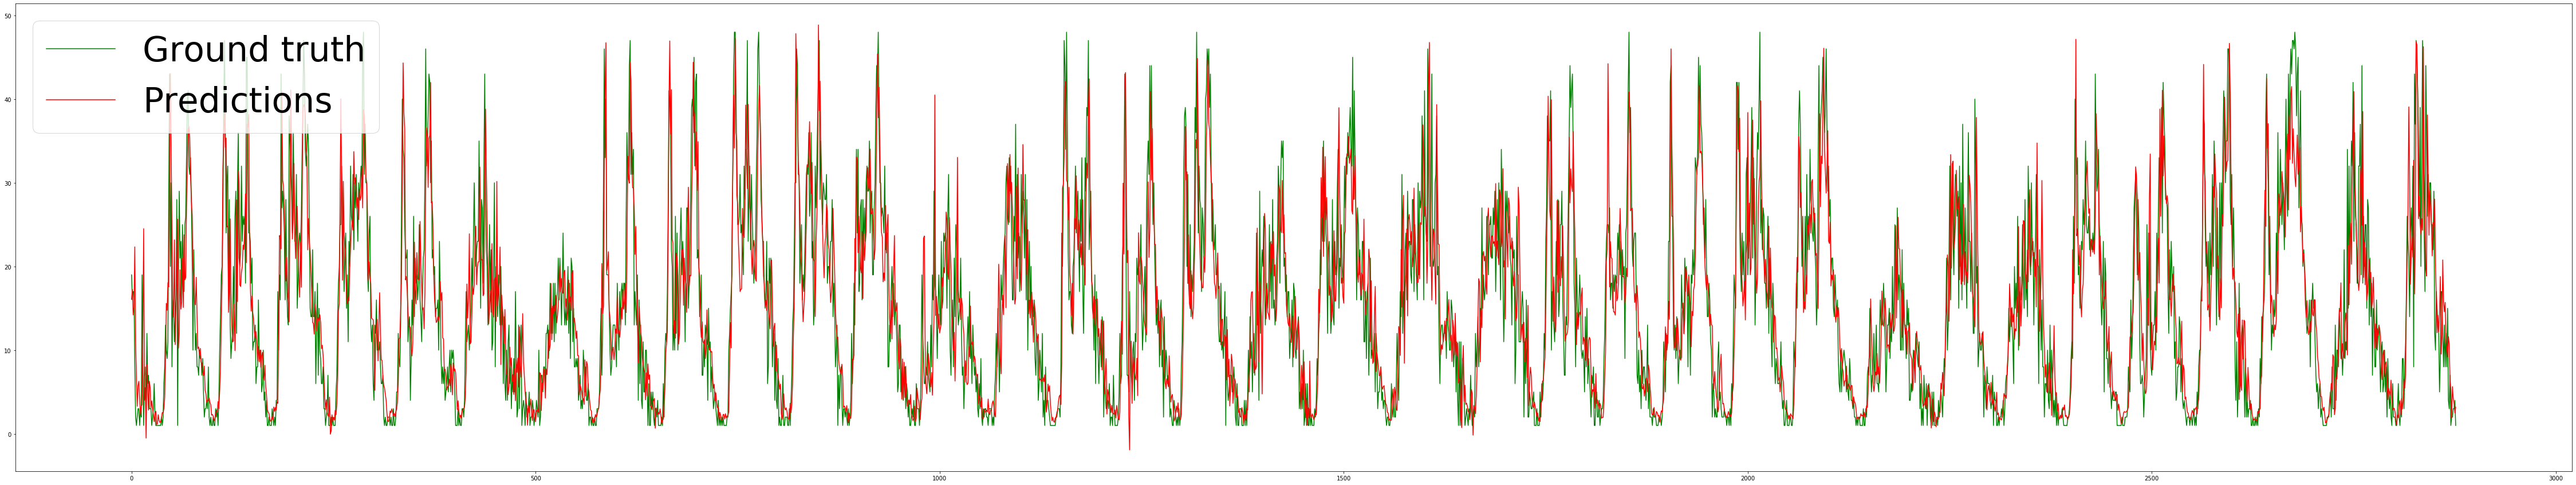

In [8]:
def predict_LSTM(model,df,size,n_steps,n_features=1):        
    ground_T=[]
    predictions=[]
    for i in range(size,df.shape[0]-n_steps):    
        x_input=array(df.bike_count.tolist()[i:i+n_steps])          
        # demonstrate prediction
        # x_input = array([70, 80, 90])
        x_input = x_input.reshape((1, n_steps, n_features))
        yhat = model.predict(x_input, verbose=0)        
        ground_T.append(df.bike_count.tolist()[i+n_steps])
        predictions.append(yhat[0][0])
    MSE_error = mean_squared_error(ground_T, predictions)
    mae=mean_absolute_error(ground_T,predictions)
    print("RMSE: "+str(math.sqrt(MSE_error)))
    print("MAE:  "+str(mae))
    pyplot.rcParams['figure.figsize'] = [80, 15]       
    pyplot.plot(ground_T,color='green')
    pyplot.plot(predictions, color='red')
    pyplot.legend(['Ground truth','Predictions'],prop={'size': 60})
    pyplot.show()
predict_LSTM(model_lstm,df,size,window)

In [9]:
 print(dt.now()-start)

0:22:17.445629
